Analysis of a running AERA experiment

In [1]:
import numpy as np, datetime, cf_units, nc_time_axis, cftime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import xarray as xr
import iris, iris_tools as itools
import aera
from notebook_metadata import create_savefig

plt.style.use('mrd_presentation')
savefig = create_savefig(dir='/g/data/p66/mrd599/temp', nb='AERA_analysis.ipynb')
%matplotlib inline

# Need this to match cftime dates
mdates.set_epoch("2000-01-01")

In [2]:
RUNID="AERA-ABS1p5-03"
expdir = f"/scratch/p66/mrd599/ACCESS-ESM1p5/exp/{RUNID}"

# Past 2250 is out of range of np.datetime64
tas = xr.load_dataset(f'{expdir}/aera_data/aera_input_{RUNID}.nc', use_cftime=True).tas
co2 = xr.load_dataset(f'{expdir}/aera_data/aera_input_{RUNID}.nc', use_cftime=True).co2

# Iris does a better job with the time dimension in these files
CO2_emiss_hist = iris.load_cube('/g/data/p66/mrd599/input4MIPs/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-1850-2014_global.nc')
CO2_emiss_126 = iris.load_cube('/g/data/p66/mrd599/input4MIPs/CO2-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-IMAGE-ssp126-1-1_gn_201501-210012_global.nc')
CO2_emiss_hist_t = CO2_emiss_hist.collapsed(['sector'], iris.analysis.SUM)[:,0,0]
CO2_emiss_126_t = CO2_emiss_126.collapsed(['sector'], iris.analysis.SUM)[:,0,0]

factor = 4*np.pi*6.371e6**2 * 365.25*86400 * 1e-12
CO2_emiss_hist_g = factor*itools.annual_mean(CO2_emiss_hist_t)
CO2_emiss_126_g = factor*itools.annual_mean(CO2_emiss_126_t)

CO2_hist = iris.load_cube('/g/data/p66/mrd599/input4MIPs/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_CMIP_UoM-CMIP-1-2-0_gr1-GMNHSH_0000-2014.nc')[:,0]
CO2_126 = iris.load_cube('/g/data/p66/mrd599/input4MIPs/mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-IMAGE-ssp126-1-2-1_gr1-GMNHSH_2015-2500.nc')[:,0]
CO2_all = np.concatenate([CO2_hist.data, CO2_126.data])


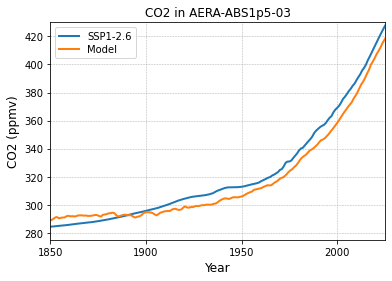

In [3]:
lastyear = 2025  # For plots
C_CO2        = 1.5188
taxis = cf_units.Unit("days since 2000-01-01 00:00", calendar="proleptic_gregorian")
t0 = taxis.date2num(datetime.datetime(1850,1,1,0,0,0))
t1 = taxis.date2num(datetime.datetime(lastyear,1,1,0,0,0))
fig, axes = plt.subplots()
# Observed + SSP1-26
yearvals = [taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in range(1850,lastyear+1)]
plt.plot(yearvals, CO2_all[1850:lastyear+1], label='SSP1-2.6')
(co2/C_CO2*1e6).plot(label='Model')

axes.set_ylabel('CO2 (ppmv)')
axes.set_title('CO2 in AERA-ABS1p5-03')
axes.grid(True)
axes.set_xlim(t0,t1)
axes.set_xlabel('Year')
date_form = mdates.DateFormatter("%Y")
axes.xaxis.set_major_formatter(date_form)
ticks = [taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in np.arange(1850,lastyear+1,50)]
axes.set_xticks(ticks)
axes.legend()
axes.set_ylim(275,430)
savefig('aera_co2.png')

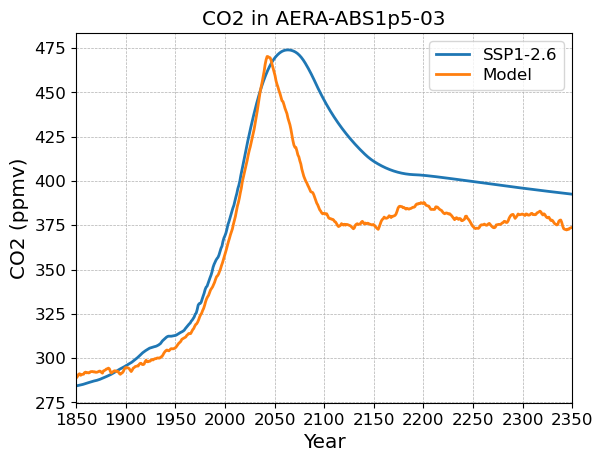

In [4]:
lastyear = 2350  # For plots
C_CO2        = 1.5188
taxis = cf_units.Unit("days since 2000-01-01 00:00", calendar="proleptic_gregorian")
# t0 = taxis.date2num(datetime.datetime(1850,1,1,0,0,0))
# t1 = taxis.date2num(datetime.datetime(lastyear,1,1,0,0,0))
t0 = taxis.date2num(cftime.DatetimeProlepticGregorian(1850,1,1))
t1 = taxis.date2num(cftime.DatetimeProlepticGregorian(lastyear,1,1))
fig, axes = plt.subplots()
# Observed + SSP1-26
# yearvals = [taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in range(1850,lastyear+1)]
yearvals = [taxis.date2num(cftime.DatetimeProlepticGregorian(y,1,1)) for y in range(1850,lastyear+1)]
plt.plot(yearvals, CO2_all[1850:lastyear+1], label='SSP1-2.6')
(co2/C_CO2*1e6).plot(label='Model')

axes.set_ylabel('CO2 (ppmv)')
axes.set_title('CO2 in AERA-ABS1p5-03')
axes.grid(True)
axes.set_xlim(t0,t1)
axes.set_xlabel('Year')
date_form = mdates.DateFormatter("%Y")
# # Undo the rotation that xarray normally uses
# fig.autofmt_xdate(rotation=0, ha='center')
axes.xaxis.set_major_formatter(date_form)
ticks = [taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in np.arange(1850,lastyear+1,50)]
# ticks = [taxis.date2num(cftime.DatetimeProlepticGregorian(y,1,1)) for y in np.arange(1850,lastyear+1,50)]
axes.set_xticks(ticks)
axes.legend()
savefig('aera_co2.png')

In [5]:
dm = {}
year = []
total_emission_budget = []
ff_emission_budget = []
for y in range(2025,lastyear+1,5):
    try:
        dm[y] = xr.load_dataset(f'{expdir}/aera_data/meta_data_{y}.nc')
    except FileNotFoundError:
        break
    year.append(y)
    # These are strings for some reason
    total_emission_budget.append(float(dm[y].total_emission_budget.values[0]))
    ff_emission_budget.append(float(dm[y].ff_emission_budget.values[0]))


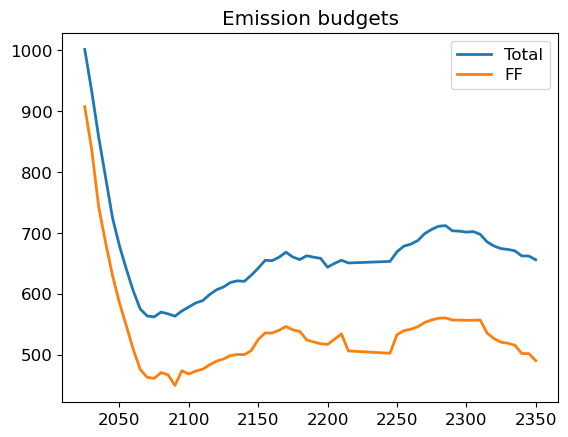

In [6]:
fig, axes = plt.subplots()
plt.plot(year, total_emission_budget, label='Total')
plt.plot(year, ff_emission_budget, label='FF')
axes.set_title('Emission budgets')
axes.legend()

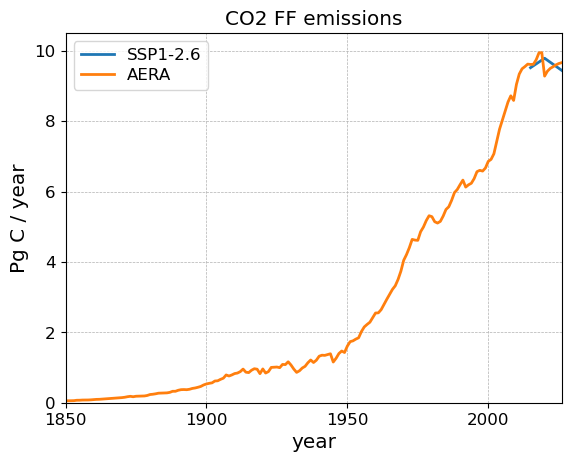

In [7]:
fig, axes = plt.subplots()
CO2_years = [CO2_emiss_126_g.coord('time').units.num2date(i).year for i in CO2_emiss_126_g.coord('time').points]
plt.plot(CO2_years, CO2_emiss_126_g.data*12/44, label='SSP1-2.6')
dm[2025].ff_emission[0][:276].plot(label='AERA')
axes.legend(loc='upper left')
axes.set_title('CO2 FF emissions')
axes.grid(True)
axes.set_xlim(1850,2026)
axes.set_ylabel('Pg C / year')
axes.set_xticks(np.arange(1850,2026,50))
axes.set_ylim(0,10.5)
savefig('aera_emissions.png')

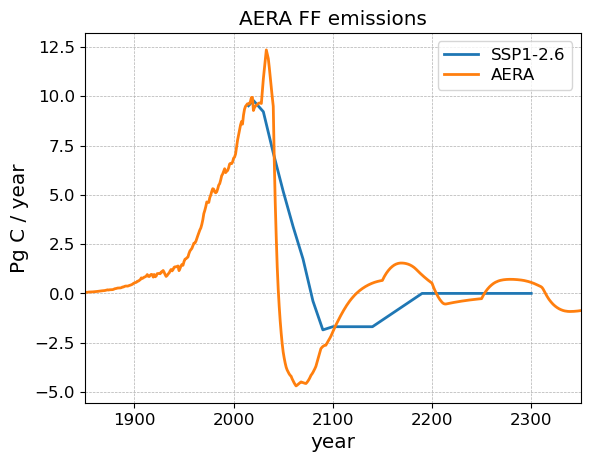

In [8]:
fig, axes = plt.subplots()
CO2_years = [CO2_emiss_126_g.coord('time').units.num2date(i).year for i in CO2_emiss_126_g.coord('time').points]
# Mienshausen et al say 126 extensions emissions constant to 2140, decreasing to 
# zero in 2190
CO2_years += [2140, 2190, 2300]
CO2_emiss = CO2_emiss_126_g.data*12/44
CO2_emiss = np.concatenate([CO2_emiss, [CO2_emiss[-1], 0., 0.]])
plt.plot(CO2_years, CO2_emiss, label='SSP1-2.6')
# for y in dm:
#     dm[y].ff_emission[0].plot(label=f'From {y}')
dm[year[-1]].ff_emission[0].plot(label='AERA')
axes.legend(loc='upper right')
axes.set_title('AERA FF emissions')
axes.grid(True)
axes.set_xlim(1850,lastyear)
axes.set_ylabel('Pg C / year')
savefig('aera_emissions.png')

NameError: name 'DateFormatter' is not defined

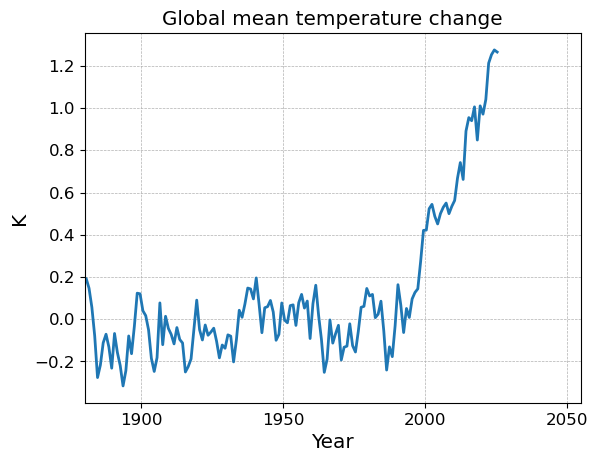

In [9]:
fig, axes = plt.subplots()
(tas[:176] - tas[:50].mean()).plot()
taxis = cf_units.Unit("days since 1970-01-01 00:00", calendar="proleptic_gregorian")
t0 = taxis.date2num(datetime.datetime(1850,1,1,0,0,0))
t1 = taxis.date2num(datetime.datetime(2025,1,1,0,0,0))

axes.set_ylabel('K')
axes.set_title('Global mean temperature change')
axes.grid(True)
axes.set_xlim(t0,t1)
axes.set_xlabel('Year')
date_form = DateFormatter("%Y")
# Undo the rotation that xarray normally uses
fig.autofmt_xdate(rotation=0, ha='center')
axes.xaxis.set_major_formatter(date_form)
ticks = [taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in np.arange(1850,2026,50)]
axes.set_xticks(ticks)
axes.grid(True)
savefig('aera_temp.png')

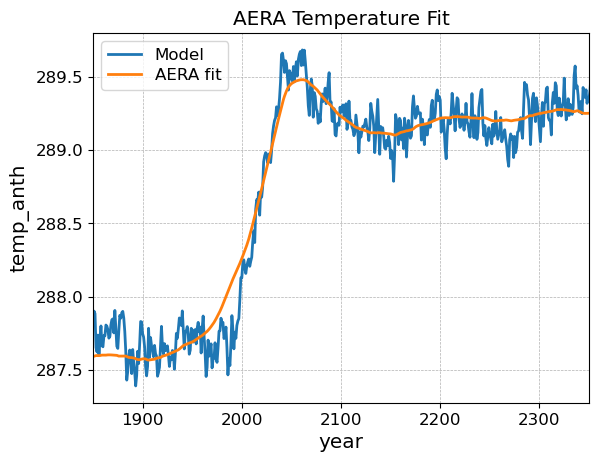

In [10]:
fig, axes = plt.subplots()
plt.plot(np.arange(1850,1850+len(tas)), tas.data, label='Model')
# for y in dm:
#     dm[y].temp_anth[0].plot(label=f'From {y}')
dm[year[-1]].temp_anth[0].plot(label='AERA fit')
axes.legend(loc='upper left')
axes.set_title('AERA Temperature Fit')
axes.grid(True)
axes.set_xlim(1850,lastyear)
savefig('aera_temp.png')

In [ ]:
tas_hist = xr.open_dataset('/g/data/p66/mrd599/CMIP6/tas_ACCESS-ESM1-5_historical.nc', use_cftime=True).tas
tas_ssp126 = xr.open_dataset('/g/data/p66/mrd599/CMIP6/tas_ACCESS-ESM1-5_ssp126.nc', use_cftime=True).tas
# Need to reload with cftime so they can be plotted together
tas = xr.load_dataset(f'{expdir}/aera_data/aera_input_{RUNID}.nc', use_cftime=True).tas

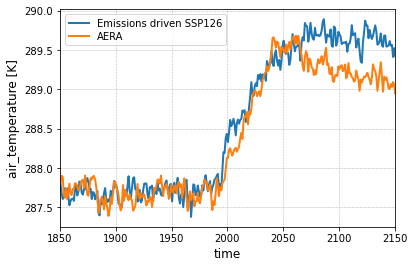

In [ ]:
fig, axes = plt.subplots()
tas_hist.plot(color='C0')
tas_ssp126[:136].plot(color='C0', label='Emissions driven SSP126')
tas.plot(color='C1', label='AERA')
axes.legend()
axes.grid(True)
taxis = cf_units.Unit("days since 2000-01-01 00:00", calendar="proleptic_gregorian")
t0 = taxis.date2num(datetime.datetime(1850,1,1,0,0,0))
t1 = taxis.date2num(datetime.datetime(2150,1,1,0,0,0))
axes.set_xlim(t0,t1)
ticks = [taxis.date2num(datetime.datetime(y,1,1,0,0,0)) for y in np.arange(1850,2151,50)]
year_fmt = nc_time_axis.CFTimeFormatter("%Y", calendar='proleptic_gregorian')
axes.xaxis.set_major_formatter(year_fmt)
axes.set_xticks(ticks);


In [ ]:
df = aera.get_base_df()

Use the following non-CO2 RF file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/nonco2_rf_ssp126_v1.dat
Use the following non-CO2 emission file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/nonco2_emis_ssp126_v3.dat
Use the following land use emission file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/lu_emis_ssp126_bern3d_adj_GCB2020_v1.dat
Use the following historical fossil fuel CO2 emission file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/co2_ff_GCP_plus_NDC_v1.dat
Use the following historical N2O concentration file: /home/599/mrd599/.local/lib/python3.9/site-packages/aera/data/n2o_conc_ssp126_v1.dat


<AxesSubplot:xlabel='year'>

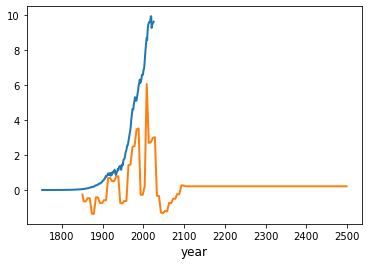

In [ ]:
df['ff_emission'].plot()
df['non_co2_emission'].plot()